In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
import cv2 as cv

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
def img_preprocess():
    img_list = []
    for img_path in glob('/content/gdrive/MyDrive/Colab_Notebooks/celeba/20000/*.jpg'):
        img = cv.imread(img_path)            #cv - 3-мерный массив, last_channel = 3, трехэлементный цвет RGB / cv 3-dim，last_channel = 3，RGB
        img = cv.resize(img, (224, 224))     #преобразование формы в (224, 224) / shape (224, 224)
        sc_img = img.astype('float') / 255   #нормализация / normalization
        img_list.append(sc_img)
    return np.asarray(img_list)

In [7]:
amg_arr = img_preprocess()

In [8]:
x_train, x_test  = train_test_split(amg_arr, test_size=0.3, random_state=0)

In [ ]:
print(amg_arr.shape)

(2000, 224, 224, 3)


In [ ]:
x_test.shape

(600, 224, 224, 3)

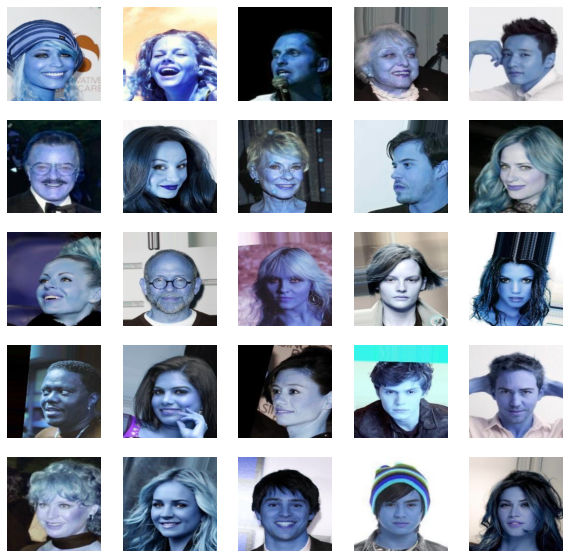

In [ ]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(amg_arr[i])
    plt.axis('off')
plt.show()

In [9]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse


def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [10]:

input_shape = (x_train.shape[1], x_train.shape[2], 3)
filters = 30
latent_dim = 112
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    x = Conv2D(filters=filters,
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')(x)
    filters *= 2
shape = K.int_shape(x)
x = Flatten()(x)
# x = Dense(32, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for i in range(2):
    filters //= 2
    x = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        activation='relu',
                        strides=1,
                        padding='same')(x)
outputs = Conv2DTranspose(filters=3,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss *= x_train.shape[1]*x_train.shape[2]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 1e-3*kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(reconstruction_loss, 'rec_loss')
vae.add_metric(kl_loss, 'kl_loss')
vae.compile(optimizer=keras.optimizers.Adam(lr=0.001))
vae.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 30) 840         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 60) 16260       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3010560)      0           conv2d_1[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))


In [14]:
vae.fit(x_train, x_train, epochs=30, batch_size=1, validation_data=(x_test, x_test)
)

Epoch 1/30


KeyboardInterrupt: ignored

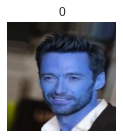

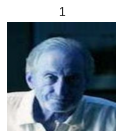

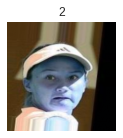

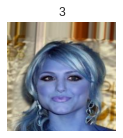

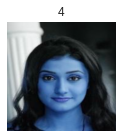

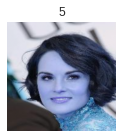

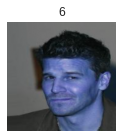

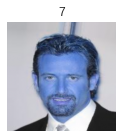

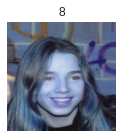

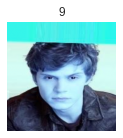

In [ ]:
for i in range(10):
  plt.figure(figsize=(2,2))
  plt.title(i)
  plt.imshow(x_test[i])
  plt.axis('off')
  plt.show()

In [ ]:
test_rec = vae.predict(x_test)

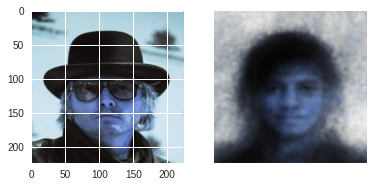

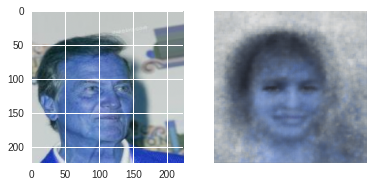

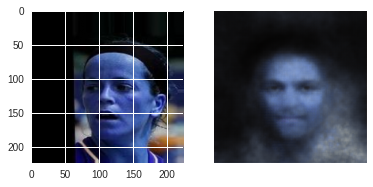

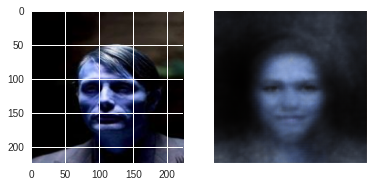

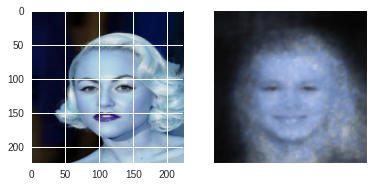

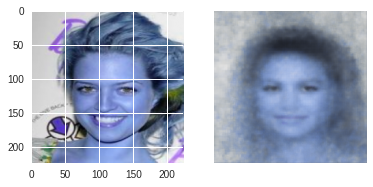

In [ ]:
for i in range(6):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(x_test[i+10], vmin=0, vmax=1)
    # plt.show()
    plt.axis('off')
    # plt.figure(figsize=(1,1))
    ax[1].imshow(test_rec[i+10], vmin=0, vmax=1)
    # plt.show()
    plt.axis('off')